In [ ]:
import pandas as pd
import numpy as np
import re
from openai import OpenAI
import os 

In [2]:
import os 

os.chdir('../')

In [ ]:
#load_dotenv()
key = ""
client = OpenAI(api_key=key)


In [4]:
movies = pd.read_csv('data/ml-latest-small/movies.csv')
ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
tag_genome = pd.read_csv('data/ml-latest-small/genome-scores.csv')
ratings_new = ratings[ratings['movieId'].isin(tag_genome.movieId.unique())]
movies_new = movies[movies['movieId'].isin(tag_genome.movieId.unique())]

movies = movies_new
ratings = ratings_new



### Plan <br>

1. setup item-item   DONE
2. setup randomized recommendations  DONE
3. setup chat-gpt user DONE
4. setup random-choice user  DONE  
5. tag-genome homogeneity
6. LLM Homogeniety DONE

In [5]:
movie_mapper = np.sort(np.array(movies.movieId.unique()))

def get_movie_hash(id):
    return np.where(movie_mapper == id)[0][0]

def get_movie_id(id):
    return movie_mapper[id]

def movie_names(movie_list):
    names = []
    for i in movie_list:
        names.append(movies[movies['movieId'] == i].title.values)
    return names

def movie_name_to_id(mov):
    return movies[movies['title'] == mov].movieId.values[0]

def extract_profile(text):
    pattern = r'<profile>(.*?)</profile>'
    match = re.search(pattern, text, re.DOTALL)
    return match.group(1).strip() if match else None

def extract_user_choice(text):
    chosen = re.search(r'<chosen>(.*?)<chosen/>', text)
    rating = re.search(r'<rating>(.*?)<rating/>', text)
    
    if chosen and rating:
        return chosen.group(1), float(rating.group(1))
    return None, None

def extract_score(text):
    match = re.search(r'<score>(.*?)<score/>', text)
    return float(match.group(1)) if match else None

In [6]:
from sklearn.neighbors import NearestNeighbors
import random

def collaborative_filtering(R, user_id, k=10):
    """
    Item-Item collaborative filtering implementation
    R: rating matrix (users x items)
    user_id: target user ID
    k: number of recommendations to return
    """
    # Transpose R to get item-item similarity matrix
    R_item = R.T  # Now each row represents an item's ratings across users
    
    # Get the items the user has rated
    user_ratings = R[user_id]
    rated_items = np.where(user_ratings != 0)[0]
    unrated_items = np.where(user_ratings == 0)[0]
    
    if len(rated_items) == 0:
        # If user hasn't rated anything, return random recommendations
        return random.sample(list(unrated_items), min(k, len(unrated_items)))
    
    # Initialize KNN for item similarity
    kNN = NearestNeighbors(n_neighbors=20, algorithm="brute", metric='cosine')
    kNN.fit(R_item)
    
    # Initialize predicted ratings
    predicted_ratings = np.zeros(R_item.shape[0])
    
    # For each unrated item
    for item in unrated_items:
        # Find k nearest items to current item
        distances, indices = kNN.kneighbors(R_item[item].reshape(1,-1), return_distance=True)
        neighbor_indices = indices[0]
        neighbor_distances = distances[0]
        
        # Convert distances to similarities
        similarities = 1 / (neighbor_distances + 1e-8)
        similarities = similarities / np.sum(similarities)
        
        # Get weighted sum of user's ratings for similar items
        weighted_sum = 0
        similarity_sum = 0
        
        for idx, neighbor_idx in enumerate(neighbor_indices):
            if neighbor_idx in rated_items:  # Only consider items the user has rated
                weighted_sum += similarities[idx] * user_ratings[neighbor_idx]
                similarity_sum += similarities[idx]
        
        # Calculate predicted rating
        if similarity_sum > 0:
            predicted_ratings[item] = weighted_sum / similarity_sum
    
    # Set predicted ratings to 0 for already rated items
    predicted_ratings[rated_items] = 0
    
    # Get top k recommendations
    recommendations = np.argsort(predicted_ratings)[::-1][:k]

    #l = []
    #for r in recommendations:
    #    l.append(get_movie_id(r))

    #R.columns[[idx for idx in recommendations]]
    return list(recommendations)

In [7]:
def random_recommendations(k=10):
    ids = np.array(movies_new.movieId.unique())
    recommendations = np.random.choice(ids, size=k, replace=False)
    return recommendations

In [8]:
random_recommendations(10)

array([ 5462,   117,  3404,  1581, 45928,  4914, 27370,  3674,   468,
       90576])

In [9]:
class Environment:
    def __init__(self, ratings_df, movies_df):
        self.ratings = ratings_df.copy()  # Create a copy of the ratings DataFrame
        self.movies = movies_df.copy()
        
def create_R(agents, env):
    m = len(env.movies.movieId)
    R = []
    for agent in agents:
        mh = agent.movie_history
        mh_idx = list(map(get_movie_id, mh))
        user_ratings = env.ratings[(env.ratings['userId'] == agent.id) & 
                                 (env.ratings['movieId'].isin(mh_idx))]
        
        # Modified row creation with error handling
        row = []
        for i in range(m):
            if i in mh:
                # Get ratings for this movie
                movie_ratings = user_ratings[user_ratings['movieId'] == get_movie_id(i)].rating
                # Check if we have any ratings
                if len(movie_ratings) > 0:
                    row.append(float(movie_ratings.iloc[0]))
                else:
                    row.append(0)  # No rating found
            else:
                row.append(0)  # Movie not in history
                
        # Convert to numpy array for easier manipulation
        row_array = np.array(row)
        
        # Calculate mean of only non-zero elements
        non_zero_mask = row_array != 0
        if non_zero_mask.any():  # check if there are any non-zero elements
            mean = np.mean(row_array[non_zero_mask])
            # Subtract mean only from non-zero elements
            row_array[non_zero_mask] = row_array[non_zero_mask] - mean
        
        R.append(row_array.tolist())

    return np.array(R)

In [10]:
class ReflexAgent:
    def __init__(self, id, env, k=10):
        self.id = id
        self.env = env  # Store reference to environment
        mh = list(self.env.ratings[self.env.ratings['userId'] == self.id]
                 .sort_values('timestamp').head(k).movieId)
        self.movie_history = list(map(get_movie_hash, mh))
    
    def get_recs(self, R):
        self.recs = collaborative_filtering(R, self.id)
        return self.recs
    
    def action(self):
        self.chosen = random.sample(self.recs, 1)[0]
        self.movie_history.append(self.chosen)

        # Create a new row as a DataFrame
        new_rating = pd.DataFrame({
            'userId': [self.id],
            'movieId': [get_movie_id(self.chosen)],
            'rating': [random.randint(0, 10)/2],
            'timestamp': [82983923]
        })
    
        # Update the ratings DataFrame in the environment
        self.env.ratings = pd.concat([self.env.ratings, new_rating], ignore_index=True)
        return self.chosen
    

In [11]:
class LLM_Agent:
    def __init__(self, id, env, k=10, method = 'random'):
        self.id = id
        self.env = env  # Store reference to environment
        mh = list(self.env.ratings[self.env.ratings['userId'] == self.id]
                 .sort_values('timestamp').head(k).movieId)
        self.movie_history = list(map(get_movie_hash, mh))
        initial_ratings = list(self.env.ratings[self.env.ratings['userId'] == self.id]
                 .sort_values('timestamp').head(k).rating)
        self.profile = self.generate_profile(mh,initial_ratings)
        
        self.method = method
    
    def get_recs(self, R):
        if self.method == 'random':
            self.recs = random_recommendations(10) 
        else:
            self.recs = collaborative_filtering(R, self.id)
        return self.recs
    
    def action(self):
        self.chosen, llm_rating = self.get_gpt_chosen(self.recs)
        self.chosen = movie_name_to_id(self.chosen)
        self.movie_history.append(get_movie_hash(self.chosen))

        # Create a new row as a DataFrame
        new_rating = pd.DataFrame({
            'userId': [self.id],
            'movieId': [self.chosen],
            'rating': [llm_rating],
            'timestamp': [82983923]
        })
    
        # Update the ratings DataFrame in the environment
        self.env.ratings = pd.concat([self.env.ratings, new_rating], ignore_index=True)
        return self.chosen
    

    def get_gpt_chosen(self,recommendations):
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f'''Based on the following user profile. Decide which movie the user will pick out of the recommendation list and what rating he is going to give it. You answer should be for the format:
<chosen>movie_name<chosen/> <rating>3<rating/>. MAKE SURE THE CHOSEN MOVIE HAS THE NAME IS WRITTEN THE SAME WAY AS THE MOVIES IN THE RECOMMENDATION LIST WITHOUT FAIL.


USER PROFILE:
{self.profile} 
RECOMMENDATIONS:
{movie_names(recommendations)}'''
                        }
                    ]
                }
            ],
            response_format={
                "type": "text"
            },
            temperature=1,
            max_tokens=1210,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )



        chosen, rating = extract_user_choice(response.choices[0].message.content)

        return chosen, rating
    

    def generate_profile(self,movie_list,initial_ratings):
        movie_list = movie_names(movie_list)
        rating_dict = {}
        for i in range(len(movie_list)):
            rating_dict[list(movie_list[i])[0]] = initial_ratings[i]
        
        ## llm request
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"Here is a dictionary which contains the movies a user has watched and the corresponding ratings given to them by the user. Your task is to create a user profile that describes what the user likes and dislikes and how he is likely to rate a movie. Observe the patterns in the ratings and the types of movies watched and think about what the user likes and dislikes and what movies he is likely to choose to watch. Enclose the user profile with <profile><profile/> tags. \n Watch History: \n {rating_dict}"
                        }
                    ]
                }
            ],
            response_format={
            "type": "text"
            },
            temperature=1,
            max_tokens=1210,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )


        ## save profile

        profile = extract_profile(response.choices[0].message.content)
        self.profile = profile
        return profile


In [12]:
# Create the environment
env = Environment(ratings, movies)

# Initialize agents with environment
users = np.array(pd.Series(ratings.userId.unique()).sample(n=10, random_state=42))
agents = [ReflexAgent(list(users).index(i), env) for i in users[:5]]

In [13]:
def simulation(timesteps,agents):
    # Run simulation
    recommendations = []
    chosen = []
    
    
    for t in range(timesteps):
        print(f"Creating R matrix for timestep {t}")
        R = create_R(agents, env)
        print(f"R matrix shape: {R.shape}")
        recs = []
        c = []
        for i, agent in enumerate(agents):
            #print(f"Processing agent {i} with {len(agent.movie_history)} movies in history")
            rec = agent.get_recs(R)
            recs.append(rec)
            c.append(agent.action())

        recommendations.append(recs)
        chosen.append(c)
        print(f"Completed timestep: {t}")
    return np.array(recommendations), np.array(chosen)

In [14]:
# Create Hooks at Recs and chosen objects 

recommendations_AR, chosen_AR  = simulation(10,agents)

Creating R matrix for timestep 0
R matrix shape: (5, 8803)
Completed timestep: 0
Creating R matrix for timestep 1
R matrix shape: (5, 8803)
Completed timestep: 1
Creating R matrix for timestep 2
R matrix shape: (5, 8803)
Completed timestep: 2
Creating R matrix for timestep 3
R matrix shape: (5, 8803)
Completed timestep: 3
Creating R matrix for timestep 4
R matrix shape: (5, 8803)
Completed timestep: 4
Creating R matrix for timestep 5
R matrix shape: (5, 8803)
Completed timestep: 5
Creating R matrix for timestep 6
R matrix shape: (5, 8803)
Completed timestep: 6
Creating R matrix for timestep 7
R matrix shape: (5, 8803)
Completed timestep: 7
Creating R matrix for timestep 8
R matrix shape: (5, 8803)
Completed timestep: 8
Creating R matrix for timestep 9
R matrix shape: (5, 8803)
Completed timestep: 9


#### Tag homogenity

In [15]:
tag_genome.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [16]:
from sklearn.preprocessing import LabelEncoder
def compute_homogeniety_old(recommendation):
    # Edge case: fewer than 2 movies
    if len(recommendation) < 2:
        return 0  # No meaningful distance to compute

    total_distance = 0
    num_pairs = 0


    # Pre-filter tag genome data for movies in the recommendation list
    filtered_tags = tag_genome[tag_genome['movieId'].isin(recommendation)].set_index('movieId')

    if len(filtered_tags) == 0:
        print(f"No tags")
        return 0
    
    

    le = LabelEncoder()
    filtered_tags.tag = le.fit_transform(filtered_tags.tagId)

    
    # Compute pairwise distances for unique movie pairs
    for i, m1 in enumerate(recommendation):
        for m2 in recommendation[i + 1:]:  # Ensure unique pairs (m1 < m2)
            # Extract tag vectors for the two movies
            print(m1,m2)

            if m2 in filtered_tags.index and m1 in filtered_tags.index:
                vec1 = np.array(filtered_tags.loc[m1].tag)
                vec2 = np.array(filtered_tags.loc[m2].tag)

                if vec1.dtype == np.int32 and vec1.size == 1:
                    vec1 = vec1.reshape(1,)
                if vec2.dtype == np.int32 and vec2.size == 1:
                    vec2 = vec2.reshape(1,)
                max_len = max(vec1.size, vec2.size)
                vec1 = np.pad(vec1, (0, max_len - vec1.size))
                vec2 = np.pad(vec2, (0, max_len - vec2.size))

          
                
        
                # Compute Euclidean distance
                distance = np.linalg.norm(vec1 - vec2)

                # Update totals
                total_distance += distance
                num_pairs += 1

    # Return the inverse of average distance as the homogeneity
    return 1/(1+ (total_distance/num_pairs)) if num_pairs > 0 else -1

In [17]:
import math
def compute_homogeniety(recommendation):
    if len(recommendation) < 2:
        return 0 

    distances = []
    rec_movies = [rec for rec in recommendation if rec in tag_genome.index]
    filtered_tags = tag_genome.loc[rec_movies]

    # Compute pairwise distances for unique movie pairs
    for i, m1 in enumerate(rec_movies):
        for m2 in rec_movies[i + 1:]:  # Ensure unique pairs (m1 < m2)
            vec1 = filtered_tags.loc[m1].values
            vec2 = filtered_tags.loc[m2].values
            sommatory = 0  
            for j in range(len(vec1)):
                sommatory += math.pow(vec1[j]-vec2[j],2)
            dist = math.sqrt(sommatory)
            distances.append(dist)

    # Return the average homogenity
    return sum(distances) / len(distances) if distances else 0

In [18]:
scores_AR = []
for i in range(len(recommendations_AR)):
    for j in range(len(recommendations_AR[0])):
        h = compute_homogeniety(recommendations_AR[i][j])
        #h = LLM_homogeneity(recommendations_AR[i][j])

        if isinstance(h, float):
            scores_AR.append(h)
        else:
            scores_AR.append(0.0)
            # print the pairs that don't return a float homogeneirty score
            print(h)

In [19]:
scores_AR

[380.8782283280682,
 373.6590012841058,
 244.09855761205986,
 320.2887016811676,
 320.2887016811676,
 367.8515809112903,
 316.85902223473147,
 86.60981340823622,
 320.28639660185553,
 320.2887016811676,
 394.7412867881495,
 423.96300054339997,
 397.1815111796328,
 320.4856922428064,
 348.2287406616421,
 320.2887016811676,
 463.406269523125,
 422.20227395451417,
 320.4856922428064,
 453.3355407209887,
 240.91385373154625,
 397.5038060763959,
 3.679979388905733,
 320.4856922428064,
 413.8713922803562,
 145.17975894711753,
 393.01834875642015,
 389.27285764984305,
 367.06522465147316,
 111.3797037122364,
 460.03935229626256,
 297.1273798564909,
 431.8589480616368,
 336.11289329606984,
 419.155708723624,
 287.7862715137802,
 386.02217687952356,
 421.4663471306475,
 472.11746910395533,
 359.24359467599345,
 392.6023278737383,
 411.8669101840201,
 434.4020846578776,
 320.4856922428064,
 395.3639528096405,
 443.73033155666053,
 356.6884641511643,
 434.4020846578776,
 320.4856922428064,
 411.6

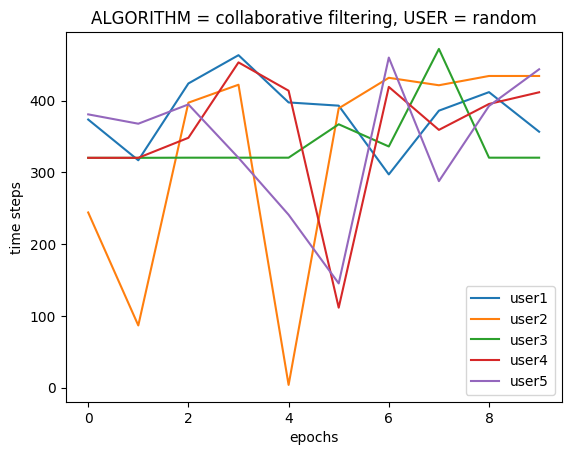

In [20]:
import  matplotlib.pyplot as plt

plt.plot([i for i in range(10)],[scores_AR[i] for i in range(1,50,5)],label='user1')
plt.plot([i for i in range(10)],[scores_AR[i] for i in range(2,50,5)],label='user2')
plt.plot([i for i in range(10)],[scores_AR[i] for i in range(3,50,5)],label='user3')
plt.plot([i for i in range(10)],[scores_AR[i] for i in range(4,50,5)],label='user4')
plt.plot([i for i in range(10)],[scores_AR[i] for i in range(0,50,5)],label='user5')
plt.xlabel('epochs')
plt.ylabel('time steps')
plt.title("ALGORITHM = collaborative filtering, USER = random")
plt.legend()


In [21]:
x= recommendations_AR[9,1]
names = movie_names(x)
print(names)

[array(['Down Periscope (1996)'], dtype=object), array(['Sense and Sensibility (1995)'], dtype=object), array([], dtype=object), array(['American President, The (1995)'], dtype=object), array(['Aguirre: The Wrath of God (Aguirre, der Zorn Gottes) (1972)'],
      dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array(['Run of the Country, The (1995)'], dtype=object)]


#### LLM Homogeneity

In [22]:
def LLM_homogeneity(recommendations):
  movie_list = movie_names(recommendations)
  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"I want you to give me a homogeneity score between 0 and 10. The homogeneity score is how similar are the movies in a given list. The dimensions of similarity can range from genres to plotlines to whatever. MAKE SURE TO ENCLOSE YOUR FINAL SCORE WITH <score><score/> TAGS. Here is the list of movies:\n{movie_list}"
          }
        ]
      }
    ],
    response_format={
      "type": "text"
    },
    temperature=0,
    max_tokens=2048,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )

  score = extract_score(response.choices[0].message.content)
  return score/10

#### LLM Agents

In [23]:
llm_agents = [LLM_Agent(list(users).index(i), env,k=30) for i in users[:5]]

In [25]:
recommendations_NC, chosen_NC  = simulation(10,llm_agents)

Creating R matrix for timestep 0
R matrix shape: (5, 8803)
Completed timestep: 0
Creating R matrix for timestep 1
R matrix shape: (5, 8803)
Completed timestep: 1
Creating R matrix for timestep 2
R matrix shape: (5, 8803)
Completed timestep: 2
Creating R matrix for timestep 3
R matrix shape: (5, 8803)
Completed timestep: 3
Creating R matrix for timestep 4
R matrix shape: (5, 8803)
Completed timestep: 4
Creating R matrix for timestep 5
R matrix shape: (5, 8803)
Completed timestep: 5
Creating R matrix for timestep 6
R matrix shape: (5, 8803)
Completed timestep: 6
Creating R matrix for timestep 7
R matrix shape: (5, 8803)
Completed timestep: 7
Creating R matrix for timestep 8
R matrix shape: (5, 8803)
Completed timestep: 8
Creating R matrix for timestep 9
R matrix shape: (5, 8803)
Completed timestep: 9


In [26]:
scores_NC = []
for i in range(len(recommendations_NC)):
    for j in range(len(recommendations_NC[0])):
        h = compute_homogeniety(recommendations_NC[i][j])
        #h = LLM_homogeneity(recommendations_AR[i][j])


        if isinstance(h, float):
            scores_NC.append(h)
        else:
            scores_NC.append(0.0)
            # print the pairs that don't return a float homogeneirty score
            print(h)

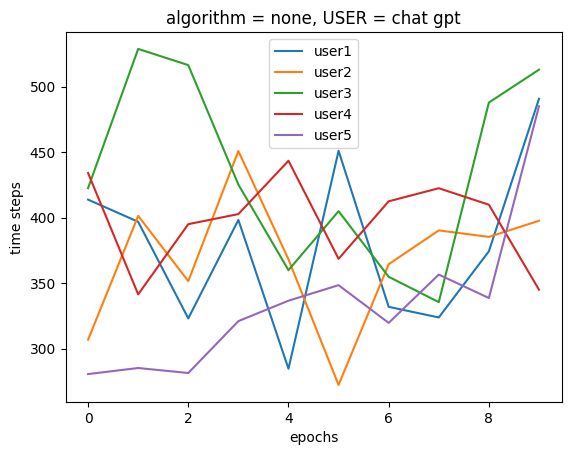

In [27]:
import  matplotlib.pyplot as plt

plt.plot([i for i in range(10)],[scores_NC[i] for i in range(1,50,5)],label='user1')
plt.plot([i for i in range(10)],[scores_NC[i] for i in range(2,50,5)],label='user2')
plt.plot([i for i in range(10)],[scores_NC[i] for i in range(3,50,5)],label='user3')
plt.plot([i for i in range(10)],[scores_NC[i] for i in range(4,50,5)],label='user4')
plt.plot([i for i in range(10)],[scores_NC[i] for i in range(0,50,5)],label='user5')
plt.xlabel('epochs')
plt.ylabel('time steps')
plt.title('algorithm = none, USER = chat gpt')
plt.legend()


# algorithm OFF, user = CHAT-GPT

chat gpt + algorithm

In [28]:
llm_agents = [LLM_Agent(list(users).index(i), env,k=30, method = "c") for i in users[:5]]

In [29]:
recommendations_AC, chosen_AC  = simulation(10,llm_agents)

Creating R matrix for timestep 0
R matrix shape: (5, 8803)
Completed timestep: 0
Creating R matrix for timestep 1
R matrix shape: (5, 8803)
Completed timestep: 1
Creating R matrix for timestep 2
R matrix shape: (5, 8803)
Completed timestep: 2
Creating R matrix for timestep 3
R matrix shape: (5, 8803)
Completed timestep: 3
Creating R matrix for timestep 4
R matrix shape: (5, 8803)
Completed timestep: 4
Creating R matrix for timestep 5
R matrix shape: (5, 8803)
Completed timestep: 5
Creating R matrix for timestep 6
R matrix shape: (5, 8803)
Completed timestep: 6
Creating R matrix for timestep 7
R matrix shape: (5, 8803)
Completed timestep: 7
Creating R matrix for timestep 8
R matrix shape: (5, 8803)
Completed timestep: 8
Creating R matrix for timestep 9
R matrix shape: (5, 8803)
Completed timestep: 9


In [30]:
scores_AC = []
for i in range(len(recommendations_AC)):
    for j in range(len(recommendations_AC[0])):
        h = compute_homogeniety(recommendations_AC[i][j])

        if isinstance(h, float):
            scores_AC.append(h)
        else:
            scores_AC.append(0.0)
            # print the pairs that don't return a float homogeneirty score
            print(h)

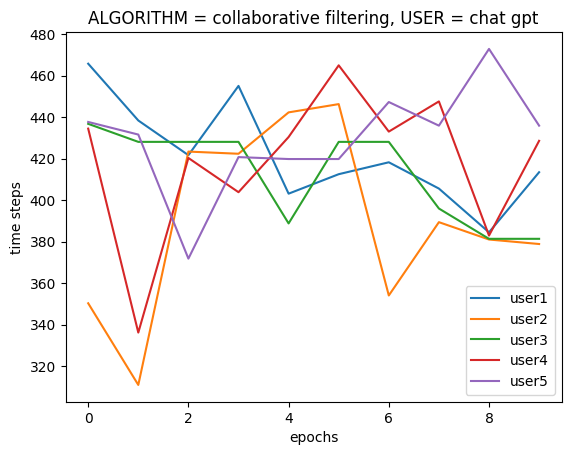

In [31]:
import  matplotlib.pyplot as plt

plt.plot([i for i in range(10)],[scores_AC[i] for i in range(1,50,5)],label='user1')
plt.plot([i for i in range(10)],[scores_AC[i] for i in range(2,50,5)],label='user2')
plt.plot([i for i in range(10)],[scores_AC[i] for i in range(3,50,5)],label='user3')
plt.plot([i for i in range(10)],[scores_AC[i] for i in range(4,50,5)],label='user4')
plt.plot([i for i in range(10)],[scores_AC[i] for i in range(0,50,5)],label='user5')
plt.xlabel('epochs')
plt.ylabel('time steps')
plt.title('ALGORITHM = collaborative filtering, USER = chat gpt')
plt.legend()

In [32]:
np.save('score_AC.npy', scores_AC)
np.save('score_AR.npy', scores_AR)
np.save('score_NC.npy', scores_NC)
np.save('recommendations_AC.npy', recommendations_AC) # algorithm - chat
np.save('recommendations_AR.npy', recommendations_AR) # algorithm - random
np.save('recommendations_NC.npy', recommendations_NC) # no algorithm - chat

np.save('chosen_AC.npy', chosen_AC)
np.save('chosen_AR.npy', chosen_AR)
np.save('chosen_NC.npy', chosen_NC)

In [33]:
print(scores_AC)
print(chosen_NC)

[437.6468943966049, 465.7077041389009, 350.32471394730044, 436.75018580396477, 434.4360513818951, 431.57907336757665, 438.3566175439564, 311.0055962789886, 428.06052977381165, 336.2184367339433, 371.83191865372487, 421.6598188226231, 423.38441014327765, 428.06052977381165, 420.30299826390143, 420.7213724745444, 455.01787811090543, 422.3350831044895, 428.06052977381165, 403.8231050025962, 419.7946252617029, 403.11617142568787, 442.26558076656664, 388.78648350780924, 430.39615046958124, 419.7946252617029, 412.4932433816253, 446.24648739491863, 428.06052977381165, 464.9198255993915, 447.25081246146533, 418.22991732882633, 354.0866796337531, 428.06052977381165, 433.0037540150249, 435.8732782081565, 405.5680455933283, 389.39167099378386, 395.9632995208878, 447.53916247349076, 472.82444428191627, 384.49215953854656, 381.0353796677528, 381.3709900431279, 382.93401457158575, 435.8732782081565, 413.4459774670648, 378.86505282033716, 381.3709900431279, 428.55591652900546]
[[ 51167  50658   2502 

In [34]:
print(recommendations_AC)

[[[  21 7409  995  359  143   17 5451 7994 5186 4781]
  [ 135 2787  996 7377 2414 7999 5579 2930 3116 2252]
  [8801 5290 1537  359 7087   13 7417 8261  955 7409]
  [7582 7690 8631   12 3447 2733 2392 2092  275 7010]
  [7063 6955   31 2733 1901 8203   12 7690   10 2092]]

 [[  21 7409  995  359  143 4356 4688 7994 4143 3803]
  [5579 8663 3116  996  198    8  135 6214 6133 7377]
  [8801   13 7417 7087 8261 5290 7409 1559 1537 1411]
  [6427   17 4781 5186 4688 7994 5451 4356 4143 3803]
  [1725 1590   31 4972 7582 2392   12   11   10 8284]]

 [[  21 7409  995  359  143   30 5186 4781 4688 7994]
  [   8 7999  448 2787 6214 2930 8663 5579 2252 6133]
  [  22   20 8801 1559  691 7087   13 8261  955 7409]
  [4781 7994 4688   17 5186 5451 6427 4356 4143 3803]
  [5073 2116   31 2838 2733 2683   12   11   10 7582]]

 [[3662 4781 2097 7994 2280 2600 5451 6427 4688   17]
  [5579 7999 1745 4688 6214    8   17  996 2414  448]
  [  16 1537 5290  691   29 1559  955 1411 8801  143]
  [  17 6427 4688 7994

In [35]:
def compute_collaborative_homogeniety(recommendations):
    homogenities = []

    for t in range(10):
        matrix = recommendations[t]
        my_dict = {}
        for row in matrix:
            for film in row:
                if not film in my_dict:
                    my_dict[film]=0
                my_dict[film]+=1   
        sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1]))
        topK = list(sorted_dict.keys())[-10:]

        #homogenities.append([])
        row_homogenities = []
        for row in matrix:
            homogenity = len(set(row) & set(topK))/len(row)
            row_homogenities.append(homogenity)
        
        homogenities.append(row_homogenities)

    return np.array(homogenities)

In [36]:
homogenities_AR = compute_collaborative_homogeniety(recommendations_AR)
homogenities_AC = compute_collaborative_homogeniety(recommendations_AC)
homogenities_NC = compute_collaborative_homogeniety(recommendations_NC)
print(homogenities_AR)
print(homogenities_AC)
print(homogenities_NC)

[[0.  0.2 0.1 1.  1. ]
 [0.  0.  0.1 0.9 1. ]
 [0.  0.1 0.8 0.1 0.9]
 [0.9 0.  0.2 0.8 0.2]
 [0.5 0.4 0.5 0.2 0.6]
 [0.2 0.1 0.6 0.4 0.9]
 [0.1 0.4 0.7 0.5 0.5]
 [0.2 0.2 0.7 0.6 0.4]
 [0.4 0.5 0.3 0.3 0.5]
 [0.6 0.2 0.5 0.3 0.4]]
[[0.2 0.  0.2 0.4 0.8]
 [0.6 0.  0.1 0.5 0.4]
 [0.5 0.  0.1 0.4 0.5]
 [0.6 0.2 0.  0.6 0.4]
 [0.7 0.2 0.  0.6 0.3]
 [0.7 0.9 0.  0.7 0. ]
 [0.5 0.  0.1 0.  0.9]
 [0.9 0.  0.  0.6 0.4]
 [0.9 0.  0.2 0.6 0.4]
 [1.  0.  0.2 0.6 0.4]]
[[0.1 0.  0.1 0.  0.9]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.1 0.  0.  1. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  1. ]]


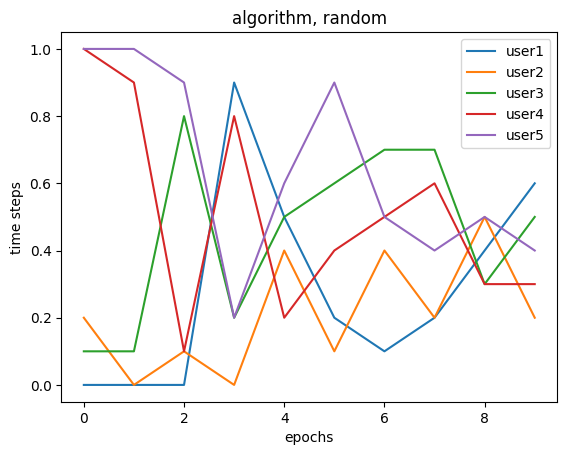

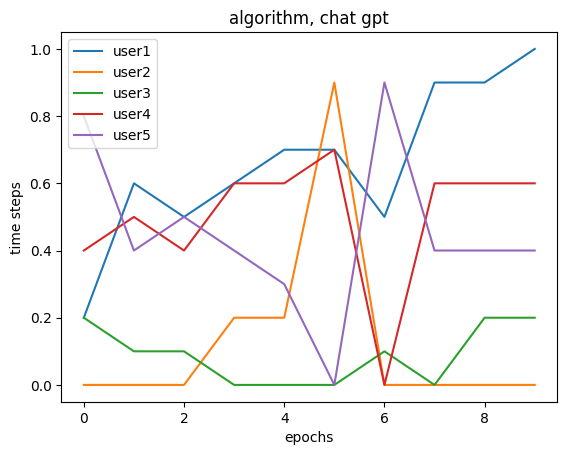

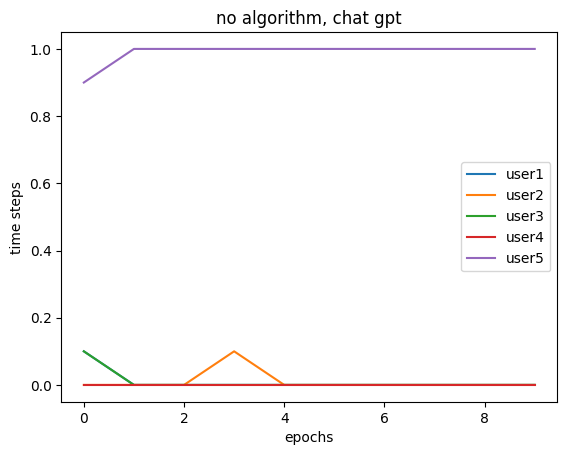

In [37]:
plt.figure()
plt.plot([i for i in range(10)],homogenities_AR[:,0] ,label='user1')
plt.plot([i for i in range(10)],homogenities_AR[:,1] ,label='user2')
plt.plot([i for i in range(10)],homogenities_AR[:,2] ,label='user3')
plt.plot([i for i in range(10)],homogenities_AR[:,3] ,label='user4')
plt.plot([i for i in range(10)],homogenities_AR[:,4] ,label='user5')
plt.xlabel('epochs')
plt.ylabel('time steps')
plt.title('algorithm, random')
plt.legend()

plt.figure()
plt.plot([i for i in range(10)],homogenities_AC[:,0] ,label='user1')
plt.plot([i for i in range(10)],homogenities_AC[:,1] ,label='user2')
plt.plot([i for i in range(10)],homogenities_AC[:,2] ,label='user3')
plt.plot([i for i in range(10)],homogenities_AC[:,3] ,label='user4')
plt.plot([i for i in range(10)],homogenities_AC[:,4] ,label='user5')
plt.xlabel('epochs')
plt.ylabel('time steps')
plt.title('algorithm, chat gpt')
plt.legend()

plt.figure()
plt.plot([i for i in range(10)],homogenities_NC[:,0] ,label='user1')
plt.plot([i for i in range(10)],homogenities_NC[:,1] ,label='user2')
plt.plot([i for i in range(10)],homogenities_NC[:,2] ,label='user3')
plt.plot([i for i in range(10)],homogenities_NC[:,3] ,label='user4')
plt.plot([i for i in range(10)],homogenities_NC[:,4] ,label='user5')
plt.xlabel('epochs')
plt.ylabel('time steps')
plt.title('no algorithm, chat gpt')
plt.legend()

In [38]:

columns = ['algorithm', 'chatgpt', 'tag_genome_score', 'final_recommendation', 'chosen', 'homogenity']
df = pd.DataFrame(columns=columns)

for i in range(5):
    tag_genome_score = scores_AC[9]
    chosen = chosen_AC[:,i]
    final_recommendation = recommendations_AC[5][i,:]
    new_row = {
        'algorithm': '1',
        'chatgpt': '1',
        'tag_genome_score': tag_genome_score,
        'final_recommendation': final_recommendation,
        'choosen': chosen,
        'homogenity': 0
    }
    new_row_df = pd.DataFrame([new_row])
    df = pd.concat([df, new_row_df], ignore_index=True)

for i in range(5):
    tag_genome_score = scores_AR[9]
    chosen = chosen_AR[:,i]
    final_recommendation = recommendations_AR[5][i,:]
    new_row = {
        'algorithm': '1',
        'chatgpt': '0',
        'tag_genome_score': tag_genome_score,
        'final_recommendation': final_recommendation,
        'choosen': chosen,
        'homogenity': 0
    }
    new_row_df = pd.DataFrame([new_row])
    df = pd.concat([df, new_row_df], ignore_index=True)

for i in range(5):
    tag_genome_score = scores_NC[9]
    chosen = chosen_NC[:,i]
    final_recommendation = recommendations_NC[5][i,:]
    new_row = {
        'algorithm': '0',
        'chatgpt': '1',
        'tag_genome_score': tag_genome_score,
        'final_recommendation': final_recommendation,
        'choosen': chosen,
        'homogenity': 0
    }
    new_row_df = pd.DataFrame([new_row])
    df = pd.concat([df, new_row_df], ignore_index=True)


print(df)



   algorithm chatgpt  tag_genome_score  \
0          1       1        336.218437   
1          1       1        336.218437   
2          1       1        336.218437   
3          1       1        336.218437   
4          1       1        336.218437   
5          1       0        320.288702   
6          1       0        320.288702   
7          1       0        320.288702   
8          1       0        320.288702   
9          1       0        320.288702   
10         0       1        341.382659   
11         0       1        341.382659   
12         0       1        341.382659   
13         0       1        341.382659   
14         0       1        341.382659   

                                 final_recommendation chosen homogenity  \
0   [3599, 7994, 2097, 2280, 5451, 6427, 4688, 518...    NaN          0   
1   [3803, 6427, 3662, 5451, 4143, 3468, 4356, 260...    NaN          0   
2   [8801, 1687, 5290, 13, 1411, 16, 995, 7409, 35...    NaN          0   
3   [17, 5451, 6427, 4688, 

C:\Users\marco\AppData\Local\Temp\ipykernel_195124\34613797.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row_df], ignore_index=True)


In [39]:
tag_name = pd.read_csv('data/ml-latest-small/genome-tags.csv')
tag_genome = pd.read_csv('data/ml-latest-small/genome-scores.csv')

movies.head(50)
tag_genome = tag_genome[tag_genome["movieId"]==2].head(50)
tag_genome = tag_genome.merge(tag_name,on="tagId").sort_values("relevance", ascending=False)
tag_genome[["tag","relevance"]].head(6)



,tag,relevance
28,adventure,0.97375
18,action,0.60900
21,adapted from:book,0.49975
20,adaptation,0.44250
19,action packed,0.40425
48,alter ego,0.32450
